# compare Scanpy’s Louvain clusters (baseline), scVI, scANVI, and openTSNE

In [ ]:
!pip install scanpy scvi-tools openTSNE --quiet
!pip install -q python-igraph louvain leidenalg --quiet


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.2/503.2 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 7.0 MB/s eta 0:00:00
   ━━

Load and Preprocess Data

In [2]:
import scanpy as sc
import scvi
import numpy as np
import time
import openTSNE
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# Load the PBMC3k dataset
adata = sc.datasets.pbmc3k()
adata.raw = adata.copy()  # Save raw counts

# Preprocessing:
sc.pp.filter_cells(adata, min_counts=3)  # Filter cells with very low counts




sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]  # Keep only highly variable genes
sc.pp.scale(adata, max_value=10)

# Compute PCA for downstream analysis
sc.tl.pca(adata, svd_solver='arpack')


/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/usr/local/lib/python3.11/dist-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


 Compute UMAP and openTSNE Embeddings

In [3]:
# First compute neighbors (required for UMAP)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

# Compute UMAP and measure computation time
start = time.time()
sc.tl.umap(adata)
umap_time = time.time() - start
print(f"UMAP Computation Time: {umap_time:.2f} seconds")

# Compute openTSNE on the first 50 PCA components
start = time.time()
tsne = openTSNE.TSNE(n_components=2, perplexity=30, metric="euclidean", random_state=42)
adata.obsm["X_tsne"] = tsne.fit(adata.obsm["X_pca"][:, :50])
tsne_time = time.time() - start
print(f"openTSNE Computation Time: {tsne_time:.2f} seconds")


UMAP Computation Time: 5.90 seconds
openTSNE Computation Time: 64.89 seconds


 Baseline Clustering with Scanpy (Louvain)

In [4]:
# Run Louvain clustering using the neighbor graph computed earlier
sc.tl.louvain(adata, resolution=0.8)
print("Baseline Louvain clusters:", adata.obs["louvain"].unique())


Baseline Louvain clusters: ['0', '3', '1', '2', '4', '5']
Categories (6, object): ['0', '1', '2', '3', '4', '5']


Train scVI for Latent Representation

In [9]:
# --- For downstream analyses (UMAP, TSNE, clustering) ---
adata_full = sc.datasets.pbmc3k()
adata_full.raw = adata_full.copy()

# Preprocessing for visualization and clustering
sc.pp.filter_cells(adata_full, min_counts=3)
sc.pp.normalize_total(adata_full, target_sum=1e4)
sc.pp.log1p(adata_full)
sc.pp.highly_variable_genes(adata_full, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_full = adata_full[:, adata_full.var.highly_variable]
sc.pp.scale(adata_full, max_value=10)
sc.tl.pca(adata_full, svd_solver='arpack')
# ... then compute UMAP, TSNE, Louvain clustering, etc.

# --- For scVI training (raw count data) ---
adata_scvi = sc.datasets.pbmc3k()  # reload raw data
sc.pp.filter_cells(adata_scvi, min_counts=3)  # filter out cells with very low counts

# Setup and train scVI on raw counts
scvi.model.SCVI.setup_anndata(adata_scvi)
scvi_model = scvi.model.SCVI(adata_scvi)
scvi_model.train()
scvi_model.save("scvi_model", save_anndata=True)

# Save scVI latent representation
adata_scvi.obsm["X_scvi"] = scvi_model.get_latent_representation()


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


 Convert scVI to scANVI and Train

reload the adata

In [10]:
adata = scvi.data.read_h5ad("scvi_model/adata.h5ad")

In [12]:
# Make sure baseline labels exist; for example, using Louvain clustering
sc.pp.neighbors(adata)
sc.tl.louvain(adata)
adata.obs["louvain"] = adata.obs["louvain"].astype(str)

# Convert scVI to scANVI using the reloaded AnnData (which now has the expected number of genes)
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="louvain",
    unlabeled_category="Unknown"
)
scanvi_model.train()

# Save scANVI latent representation and predicted labels
adata.obsm["X_scanvi"] = scanvi_model.get_latent_representation()
adata.obs["scanvi_labels"] = scanvi_model.predict()
print("Predicted scANVI labels:", adata.obs["scanvi_labels"].unique())


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 32738 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
INFO     Training for 10 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Predicted scANVI labels: ['0' '4' '2' '1' '7' '5' '9' '3' '6' '8' '10']


 Compute Clustering Metrics (ARI, NMI, and Silhouette Scores)

In [17]:
# --- For scVI training (raw count data) ---
adata_scvi = sc.datasets.pbmc3k()  # reload raw data
sc.pp.filter_cells(adata_scvi, min_counts=3)  # filter out cells with very low counts

# Setup and train scVI on raw counts
scvi.model.SCVI.setup_anndata(adata_scvi)
scvi_model = scvi.model.SCVI(adata_scvi)
scvi_model.train()

# Save the scVI model along with AnnData
# scvi_model.save("scvi_model", save_anndata=True)

# Optionally, compute and store the latent representation now (for reference)
adata_scvi.obsm["X_scvi"] = scvi_model.get_latent_representation()


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


In [18]:
# Reload the AnnData that was saved with the scVI model
adata = scvi.data.read_h5ad("scvi_model/adata.h5ad")

# Reload the scVI model using the reloaded AnnData
scvi_model = scvi.model.SCVI.load("scvi_model", adata=adata)

# Compute and store the latent representation in the reloaded AnnData
adata.obsm["X_scvi"] = scvi_model.get_latent_representation()


INFO     File scvi_model/model.pt already downloaded                                                               


In [19]:
# Make sure baseline labels exist; here we perform Louvain clustering as an example
sc.pp.neighbors(adata)
sc.tl.louvain(adata)
adata.obs["louvain"] = adata.obs["louvain"].astype(str)

# Convert scVI to scANVI using the reloaded AnnData
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key="louvain",
    unlabeled_category="Unknown"
)
scanvi_model.train()

# Save scANVI latent representation and predicted labels
adata.obsm["X_scanvi"] = scanvi_model.get_latent_representation()
adata.obs["scanvi_labels"] = scanvi_model.predict()
print("Predicted scANVI labels:", adata.obs["scanvi_labels"].unique())


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 32738 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


INFO     Training for 10 epochs.                                                                                   


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/10 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Predicted scANVI labels: ['0' '4' '2' '1' '7' '5' '9' '3' '6' '8' '10']


In [22]:
# Convert baseline Louvain labels to numeric codes
adata.obs["louvain_numeric"] = adata.obs["louvain"].astype("category").cat.codes
baseline_labels = adata.obs["louvain_numeric"]

# --- Clustering in scVI latent space ---
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.louvain(adata, key_added="scvi_louvain")
scvi_labels = adata.obs["scvi_louvain"].astype("category").cat.codes


sc.tl.umap(adata)
sc.tl.tsne(adata)
# --- Clustering in openTSNE space ---
sc.pp.neighbors(adata, use_rep="X_tsne")
sc.tl.louvain(adata, key_added="tsne_louvain")
tsne_labels = adata.obs["tsne_louvain"].astype("category").cat.codes

# For scANVI, convert predicted labels to numeric codes
scanvi_labels = adata.obs["scanvi_labels"].astype("category").cat.codes

# Compute ARI and NMI metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
ari_scvi = adjusted_rand_score(baseline_labels, scvi_labels)
nmi_scvi = normalized_mutual_info_score(baseline_labels, scvi_labels)
ari_scanvi = adjusted_rand_score(baseline_labels, scanvi_labels)
nmi_scanvi = normalized_mutual_info_score(baseline_labels, scanvi_labels)
ari_tsne = adjusted_rand_score(baseline_labels, tsne_labels)
nmi_tsne = normalized_mutual_info_score(baseline_labels, tsne_labels)

print(f"ARI - Baseline vs scVI: {ari_scvi:.2f}, Baseline vs scANVI: {ari_scanvi:.2f}, Baseline vs openTSNE: {ari_tsne:.2f}")
print(f"NMI - Baseline vs scVI: {nmi_scvi:.2f}, Baseline vs scANVI: {nmi_scanvi:.2f}, Baseline vs openTSNE: {nmi_tsne:.2f}")

# Compute silhouette scores for each embedding using the baseline numeric labels
from sklearn.metrics import silhouette_score
silhouette_scvi = silhouette_score(adata.obsm["X_scvi"], baseline_labels)
silhouette_scanvi = silhouette_score(adata.obsm["X_scanvi"], baseline_labels)
silhouette_umap = silhouette_score(adata.obsm["X_umap"], baseline_labels)
silhouette_tsne = silhouette_score(adata.obsm["X_tsne"], baseline_labels)

print(f"Silhouette Scores - scVI: {silhouette_scvi:.2f}, scANVI: {silhouette_scanvi:.2f}, UMAP: {silhouette_umap:.2f}, openTSNE: {silhouette_tsne:.2f}")


ARI - Baseline vs scVI: 0.38, Baseline vs scANVI: 0.53, Baseline vs openTSNE: 0.44
NMI - Baseline vs scVI: 0.53, Baseline vs scANVI: 0.65, Baseline vs openTSNE: 0.69
Silhouette Scores - scVI: 0.04, scANVI: 0.06, UMAP: 0.08, openTSNE: 0.32


In [23]:
# Convert baseline Louvain labels to numeric codes
adata.obs["louvain_numeric"] = adata.obs["louvain"].astype("category").cat.codes
baseline_labels = adata.obs["louvain_numeric"]

# --- Clustering in scVI latent space ---
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.louvain(adata, key_added="scvi_louvain")
scvi_labels = adata.obs["scvi_louvain"].astype("category").cat.codes

# --- Clustering in openTSNE space ---
sc.pp.neighbors(adata, use_rep="X_tsne")
sc.tl.louvain(adata, key_added="tsne_louvain")
tsne_labels = adata.obs["tsne_louvain"].astype("category").cat.codes

# For scANVI, convert predicted labels to numeric codes
scanvi_labels = adata.obs["scanvi_labels"].astype("category").cat.codes

# Compute ARI and NMI metrics
ari_scvi = adjusted_rand_score(baseline_labels, scvi_labels)
nmi_scvi = normalized_mutual_info_score(baseline_labels, scvi_labels)
ari_scanvi = adjusted_rand_score(baseline_labels, scanvi_labels)
nmi_scanvi = normalized_mutual_info_score(baseline_labels, scanvi_labels)
ari_tsne = adjusted_rand_score(baseline_labels, tsne_labels)
nmi_tsne = normalized_mutual_info_score(baseline_labels, tsne_labels)

print(f"ARI - Baseline vs scVI: {ari_scvi:.2f}, Baseline vs scANVI: {ari_scanvi:.2f}, Baseline vs openTSNE: {ari_tsne:.2f}")
print(f"NMI - Baseline vs scVI: {nmi_scvi:.2f}, Baseline vs scANVI: {nmi_scanvi:.2f}, Baseline vs openTSNE: {nmi_tsne:.2f}")

# Compute silhouette scores for each embedding using the baseline numeric labels
silhouette_scvi = silhouette_score(adata.obsm["X_scvi"], baseline_labels)
silhouette_scanvi = silhouette_score(adata.obsm["X_scanvi"], baseline_labels)
silhouette_umap = silhouette_score(adata.obsm["X_umap"], baseline_labels)
silhouette_tsne = silhouette_score(adata.obsm["X_tsne"], baseline_labels)

print(f"Silhouette Scores - scVI: {silhouette_scvi:.2f}, scANVI: {silhouette_scanvi:.2f}, UMAP: {silhouette_umap:.2f}, openTSNE: {silhouette_tsne:.2f}")


ARI - Baseline vs scVI: 0.38, Baseline vs scANVI: 0.53, Baseline vs openTSNE: 0.44
NMI - Baseline vs scVI: 0.53, Baseline vs scANVI: 0.65, Baseline vs openTSNE: 0.69
Silhouette Scores - scVI: 0.04, scANVI: 0.06, UMAP: 0.08, openTSNE: 0.32


Visualize Clustering Results

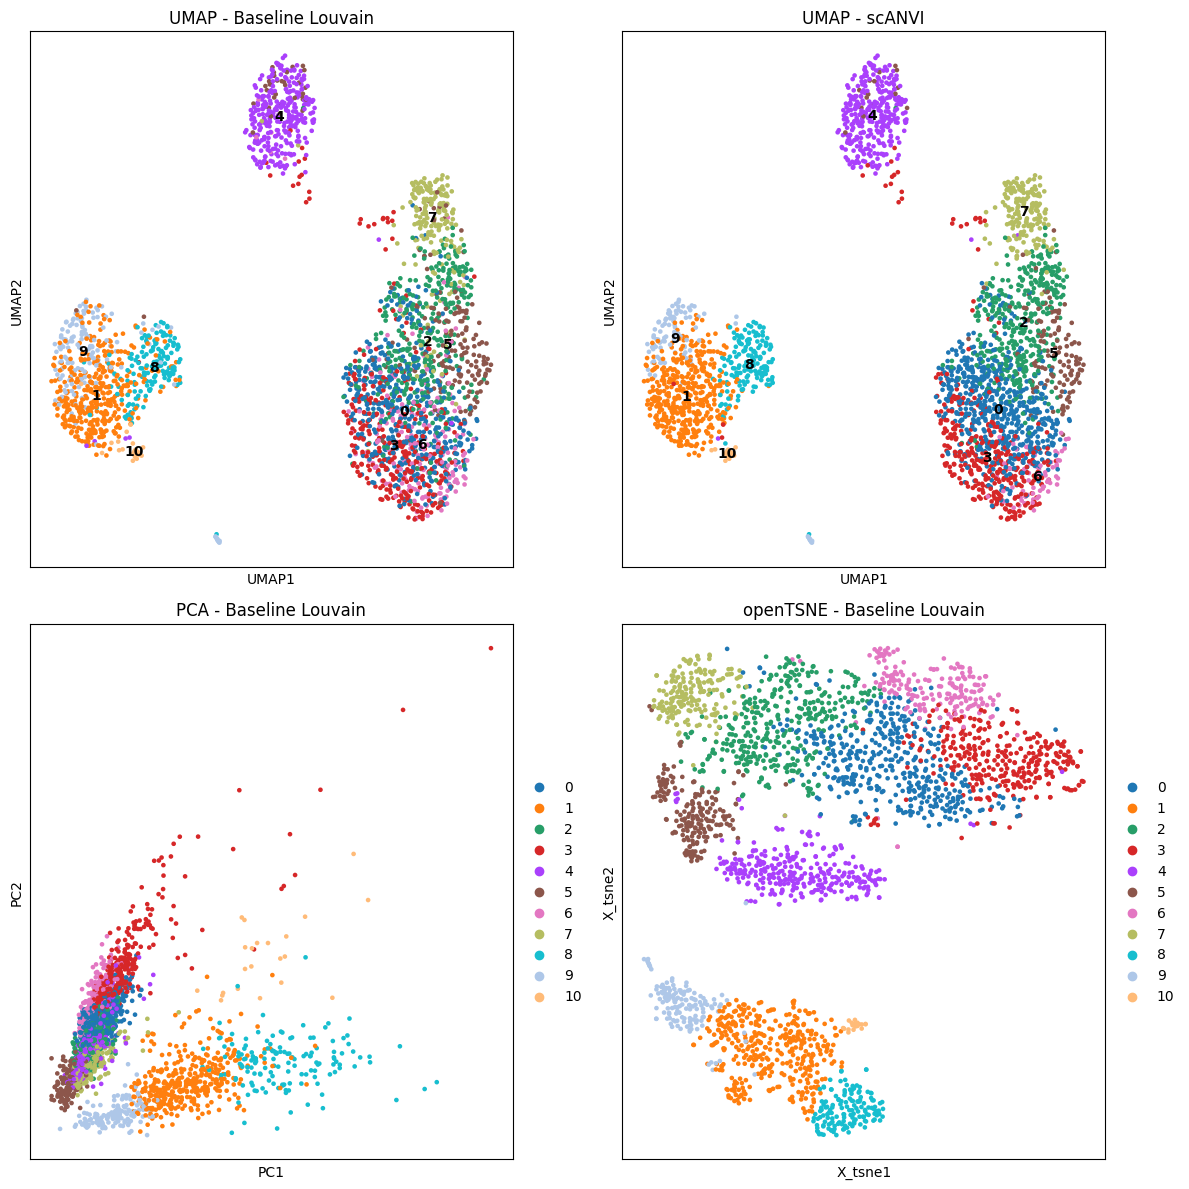

In [24]:

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# UMAP with baseline Louvain clusters
sc.pl.umap(adata, color="louvain", legend_loc="on data", title="UMAP - Baseline Louvain", ax=axes[0, 0], show=False)

# UMAP with scANVI clusters
sc.pl.umap(adata, color="scanvi_labels", legend_loc="on data", title="UMAP - scANVI", ax=axes[0, 1], show=False)

# PCA with baseline Louvain clusters
sc.pl.pca(adata, color="louvain", title="PCA - Baseline Louvain", ax=axes[1, 0], show=False)

# openTSNE with baseline Louvain clusters
sc.pl.embedding(adata, basis="X_tsne", color="louvain", title="openTSNE - Baseline Louvain", ax=axes[1, 1], show=False)

plt.tight_layout()
plt.show()
